# Spatial single-cell aging clocks

This notebook generates statistics and plots for evaluating and comparing the performance of spatial aging clocks and other clock variations. Training and cross-validation of aging clocks are done in `cv_train_clock.py` and `cv_train_clock_Ksmooth.py` and are needed as inputs for this notebook.

**Associated manuscript figures/tables:**
- Figures: 2b,c
- Extended Data Figures: 5e,h; 6a

**Inputs required:**
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad` - AnnData object for coronal sections data with spatial aging clock predictions (generated from `cv_train_clock.py`)
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_singlecell.h5ad` - AnnData object for coronal sections data with single-cell clock predictions (generated from `cv_train_clock.py`)
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_B1k_singlecellpred_smoothed.h5ad` - AnnData object for coronal sections data with single-cell (PB) aging clock predictions (generated from `cv_train_clock.py`)
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh{k}.h5ad` for `k` in `[5,10,15,20,25,30,35,40]` - AnnData objects for coronal sections data with spatial aging clock predictions with different SpatialSmooth neighbor choices (generated from `cv_train_clock_Ksmooth.py`)


**Conda environment used**: `requirements/merfish.txt`


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, lasso_path, LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr, spearmanr
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import seaborn as sns

from clock_preprocessing import *

In [2]:
# function for computing confidence interval for correlations

def correlation_confidence_interval(r,n,ci=0.95):
    '''
    Given correlation (r), number of samples (n), and confidence interval (ci).
    Computes the confidence interval lower and upper bounds for r
    '''
    from scipy.stats import norm
    import math
    
    z = norm.ppf(1-(1-ci)/2)
    lower = math.tanh(math.atanh(r)-z/np.sqrt(n-3))
    upper = math.tanh(math.atanh(r)+z/np.sqrt(n-3))
    
    return((lower,upper))

In [3]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

### Single-cell

In [3]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_singlecell.h5ad")

In [ ]:
nrows = 2
ncols = 9

fig, axs = plt.subplots(2, 9, figsize=(24,8), sharex=True, sharey=False)

celltype_list = []
r_list = []
mae_list = []

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = list(np.unique(adata.obs['celltype']))[counter]
        sub_adata = adata[adata.obs["celltype"]==celltype,:]
        
        # make plot
        axs[i,j].scatter(sub_adata.obs['age'], sub_adata.obs['predicted_age'], alpha=0.1, c='0.5', rasterized=True)
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_adata.obs['age'], sub_adata.obs['predicted_age'])
        mae = np.mean(np.abs(sub_adata.obs['age']-sub_adata.obs['predicted_age']))
        axs[i,j].annotate(f"R = {round(r,2)}", (0.3, 0.05), xycoords='axes fraction', fontsize=14)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        
        counter += 1

# make figure
fig.suptitle("Lasso, Leave-Mouse-Out-CV", fontsize=16)
fig.supxlabel("Actual Age (months)", fontsize=16)
fig.supylabel("Predicted Age (months)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/clocks/pseudobulked/lasso_loocv_predicted_age_correlation_singlecell.pdf",
            dpi=300, bbox_inches='tight')
plt.show()


# save stats
stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, mae_list]).T, columns=["celltype", "pearson", "mean_abs_err"])
stat_df.to_csv("results/clocks/stats/lasso_loocv_predicted_age_correlation_singlecell.csv", index=False)

### Pseudobulked (random) -- SingleCell (PB)

In [7]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_B1k_singlecellpred_smoothed.h5ad")

In [ ]:
nrows = 2
ncols = 9

fig, axs = plt.subplots(2, 9, figsize=(24,8), sharex=True, sharey=False)

celltype_list = []
r_list = []
mae_list = []

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = list(np.unique(adata.obs['celltype']))[counter]
        sub_adata = adata[adata.obs["celltype"]==celltype,:]
        
        # make plot
        axs[i,j].scatter(sub_adata.obs['age'], sub_adata.obs['predicted_age'], alpha=0.1, c='0.5', rasterized=True)
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_adata.obs['age'], sub_adata.obs['predicted_age'])
        mae = np.mean(np.abs(sub_adata.obs['age']-sub_adata.obs['predicted_age']))
        axs[i,j].annotate(f"R = {round(r,2)}", (0.3, 0.05), xycoords='axes fraction', fontsize=14)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        
        counter += 1

# make figure
fig.suptitle("Lasso, Leave-Mouse-Out-CV", fontsize=16)
fig.supxlabel("Actual Age (months)", fontsize=16)
fig.supylabel("Predicted Age (months)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/clocks/pseudobulked/lasso_loocv_predicted_age_correlation_n30_B1k_singlecellpred_smoothed.pdf",
            dpi=300, bbox_inches='tight')
plt.show()


# save stats
stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, mae_list]).T, columns=["celltype", "pearson", "mean_abs_err"])
stat_df.to_csv("results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_B1k_singlecellpred_smoothed.csv", index=False)

## SpatialSmooth (spatial aging clocks)

In [ ]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

In [ ]:
nrows = 2
ncols = 9

fig, axs = plt.subplots(2, 9, figsize=(24,8), sharex=True, sharey=False)

celltype_list = []
r_list = []
mae_list = []

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = list(np.unique(adata.obs['celltype']))[counter]
        sub_adata = adata[adata.obs["celltype"]==celltype,:]
        
        # make plot
        axs[i,j].scatter(sub_adata.obs['age'], sub_adata.obs['predicted_age'], alpha=0.1, c='0.5', rasterized=True)
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_adata.obs['age'], sub_adata.obs['predicted_age'])
        mae = np.mean(np.abs(sub_adata.obs['age']-sub_adata.obs['predicted_age']))
        axs[i,j].annotate(f"R = {round(r,2)}", (0.3, 0.05), xycoords='axes fraction', fontsize=14)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        
        counter += 1

# make figure
fig.suptitle("Lasso, Leave-Mouse-Out-CV", fontsize=16)
fig.supxlabel("Actual Age (months)", fontsize=16)
fig.supylabel("Predicted Age (months)", fontsize=16)
fig.tight_layout()
plt.show()

# Final Figures for clock evaluation

In [12]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

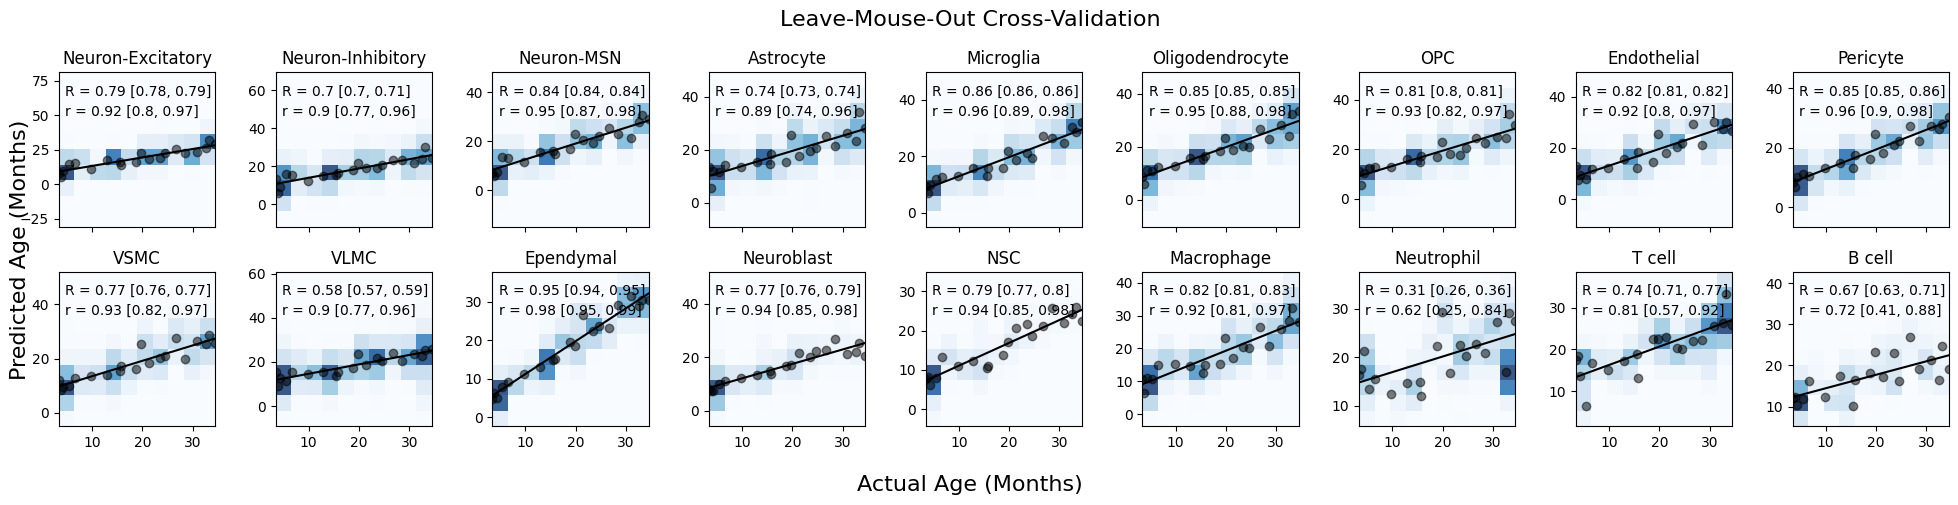

In [14]:
nrows = 2
ncols = 9

fig, axs = plt.subplots(2, 9, figsize=(20,5), sharex=True, sharey=False)

celltype_list = []
r_list = []
r_list_median = []
mae_list = []

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = list(pd.unique(adata.obs.celltype).sort_values())[counter]
        sub_adata = adata[adata.obs["celltype"]==celltype,:]
        
        # make plot
        axs[i,j].hist2d(sub_adata.obs['age'], sub_adata.obs['predicted_age'], alpha=0.8, cmap='Blues', bins=10)
        axs[i,j].scatter(sub_adata.obs.groupby(["mouse_id"])["age"].median(), sub_adata.obs.groupby(["mouse_id"])["predicted_age"].median(), c='k', alpha=0.5)
        b, a = np.polyfit(sub_adata.obs.groupby(["mouse_id"])["age"].median(), sub_adata.obs.groupby(["mouse_id"])["predicted_age"].median(), deg=1)
        xseq = np.linspace(np.min(sub_adata.obs['age']),np.max(sub_adata.obs['age']),100)
        axs[i,j].plot(xseq, a + b * xseq, color="k")
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_adata.obs['age'], sub_adata.obs['predicted_age'])
        ci = correlation_confidence_interval(r,len(sub_adata.obs['age']),0.95)
        r_med,p_med = pearsonr(sub_adata.obs.groupby(["mouse_id"])["age"].median(), sub_adata.obs.groupby(["mouse_id"])["predicted_age"].median())
        ci_med = correlation_confidence_interval(r_med,len(sub_adata.obs.groupby(["mouse_id"])["age"].median()),0.95)
        mae = np.mean(np.abs(sub_adata.obs['age']-sub_adata.obs['predicted_age']))
        axs[i,j].annotate(f"R = {round(r,2)} [{round(ci[0],2)}, {round(ci[1],2)}]", (0.04, 0.85), xycoords='axes fraction', fontsize=10)
        axs[i,j].annotate(f"r = {round(r_med,2)} [{round(ci_med[0],2)}, {round(ci_med[1],2)}]", (0.04, 0.72), xycoords='axes fraction', fontsize=10)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        r_list_median.append(r_med)
        
        counter += 1

# make figure
fig.suptitle("Leave-Mouse-Out Cross-Validation", fontsize=16)
fig.supxlabel("Actual Age (Months)", fontsize=16)
fig.supylabel("Predicted Age (Months)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/clocks/pseudobulked/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth.pdf",
            bbox_inches='tight')
plt.show()


# save stats
stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, r_list_median, mae_list]).T, columns=["celltype", "pearson", "pearson_median", "mean_abs_err"])
stat_df.to_csv("results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv", index=False)

### Visualize as density plot (young vs old)

In [3]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

In [15]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']
adata = adata[adata.obs.celltype.isin(restricted_celltype_subset)]

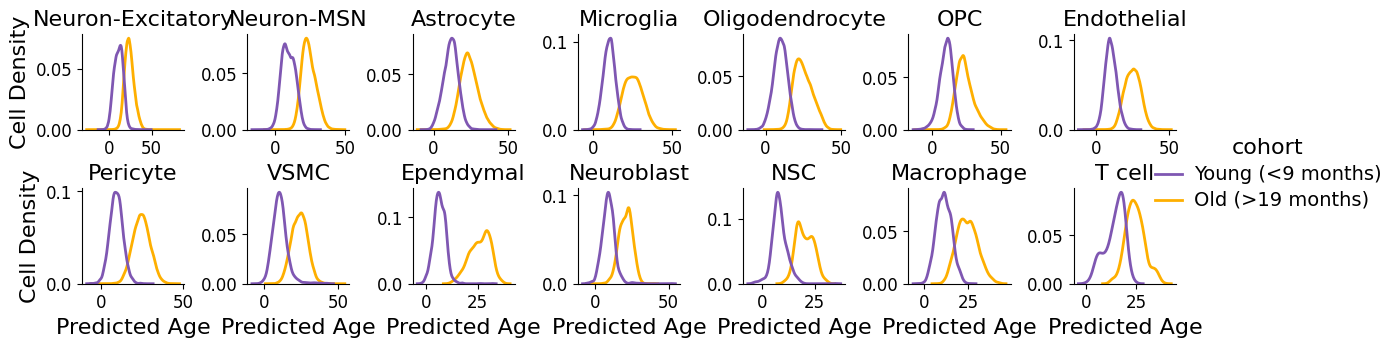

In [16]:
# Visualized as binary distributions

df = adata.obs[["age","predicted_age","cohort","celltype"]].copy()
df = df[(df["age"]<9)|(df["age"]>19)]
df["cohort"] = ["Young (<9 months)" if x < 9 else "Old (>19 months)" for x in df["age"].values]

palette = {"Young (<9 months)":"#7F57B2",
           "Old (>19 months)":"#FEAF00"}

ncols = 7
g = sns.displot(data=df, x="predicted_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=12/ncols, aspect=1,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["Young (<9 months)", "Old (>19 months)"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/clocks/coronal_YO_density_spatialsmooth.pdf", bbox_inches='tight')
plt.show()

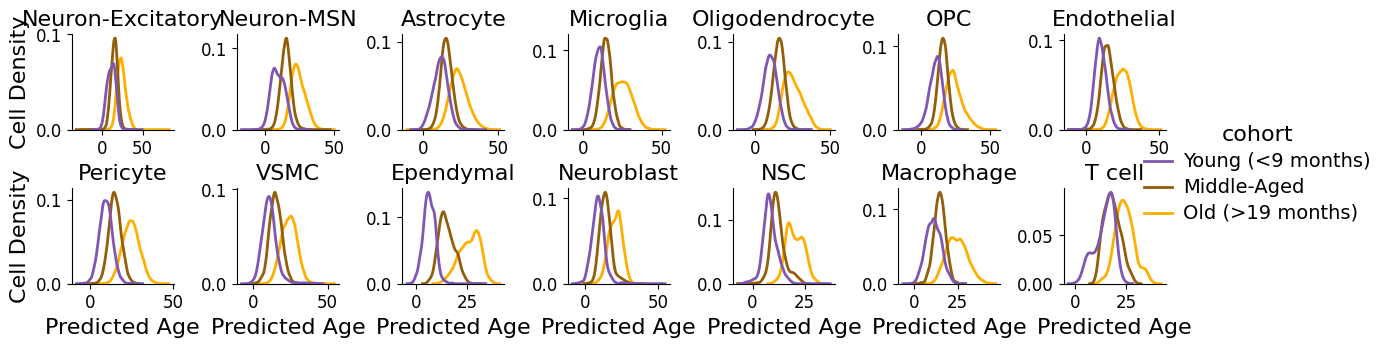

In [18]:
# Visualized as tertiary distributions

df = adata.obs[["age","predicted_age","cohort","celltype"]].copy()
df["cohort"] = ["Young (<9 months)" if x < 9 else "Old (>19 months)" if x > 19 else "Middle-Aged" for x in df["age"].values]

palette = {"Young (<9 months)":"#7F57B2",
           "Middle-Aged":"#935E09",
           "Old (>19 months)":"#FEAF00"}

ncols = 7
g = sns.displot(data=df, x="predicted_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=12/ncols, aspect=1,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["Young (<9 months)","Middle-Aged", "Old (>19 months)"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/clocks/coronal_YO_density3_spatialsmooth.pdf", bbox_inches='tight')
plt.show()

# Compare models with dotplots

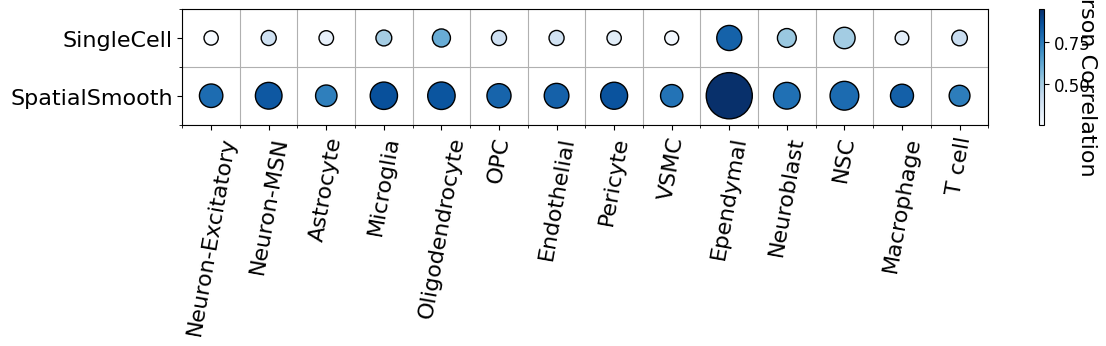

In [23]:
filepaths = ["results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv",
             "results/clocks/stats/lasso_loocv_predicted_age_correlation_singlecell.csv"]
names = ["SpatialSmooth", "SingleCell"]

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories(celltypes_full)
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(13,1.5))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="Blues",edgecolor='black',linewidth=1)
ax.add_collection(col)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)


plt.savefig("plots/clocks/comparison_train_test_same_SpatialSmooth_SingleCell.pdf", bbox_inches='tight')
plt.show()

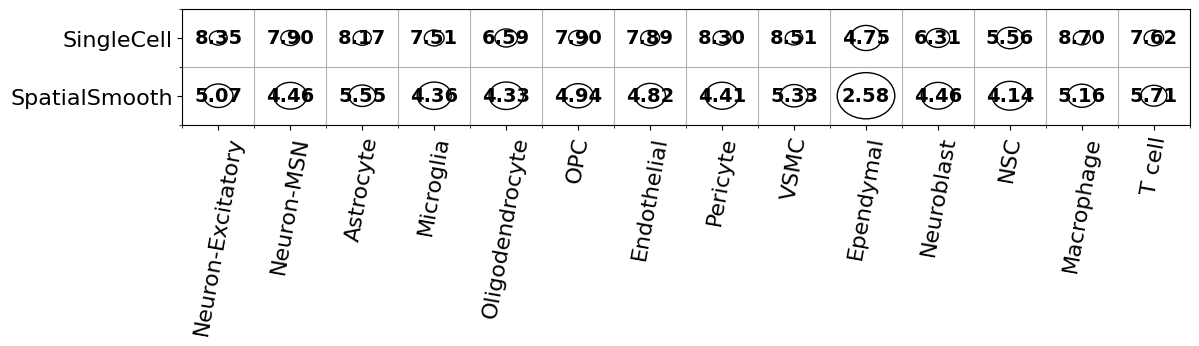

In [29]:
# PRINT OUT LABELS FOR SIZE LEGEND


filepaths = ["results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv",
             "results/clocks/stats/lasso_loocv_predicted_age_correlation_singlecell.csv"]
names = ["SpatialSmooth", "SingleCell"]

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories(celltypes_full)
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(13,1.5))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
# Create the figure and axis

# Create circles and annotate with mean_abs_err values
for r, j, i, value in zip(R.flat, x.flat, y.flat, comb_df["mean_abs_err"].values):
    circle = plt.Circle((j, i), radius=r, edgecolor='black', linewidth=1, facecolor="None")
    ax.add_patch(circle)
    ax.annotate(f"{value:.2f}", (j, i), color='black', weight='bold', ha='center', va='center', fontsize=14)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)


# plt.savefig("plots/clocks/comparison_train_test_same_SpatialSmooth_SingleCell.pdf", bbox_inches='tight')
plt.show()

# Clock performance as function of SpatialSmooth neighborhood size

In [3]:
# get stats

k_values = [5,10,15,25,30,35,40]

for k in k_values:
    adata = sc.read_h5ad(f"results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh{k}.h5ad")

    nrows = 2
    ncols = 9

    celltype_list = []
    r_list = []
    r_list_median = []
    mae_list = []

    counter = 0
    for i in range(nrows):
        for j in range(ncols):

            celltype = list(pd.unique(adata.obs.celltype).sort_values())[counter]
            sub_adata = adata[adata.obs["celltype"]==celltype,:]

            r,p = pearsonr(sub_adata.obs['age'], sub_adata.obs['predicted_age'])
            r_med,p_med = pearsonr(sub_adata.obs.groupby(["mouse_id"])["age"].median(), sub_adata.obs.groupby(["mouse_id"])["predicted_age"].median())
            mae = np.mean(np.abs(sub_adata.obs['age']-sub_adata.obs['predicted_age']))

            # append stats
            celltype_list.append(celltype)
            r_list.append(r)
            mae_list.append(mae)
            r_list_median.append(r_med)

            counter += 1

    # save stats
    stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, r_list_median, mae_list]).T, columns=["celltype", "pearson", "pearson_median", "mean_abs_err"])
    stat_df.to_csv(f"results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh{k}.csv", index=False)

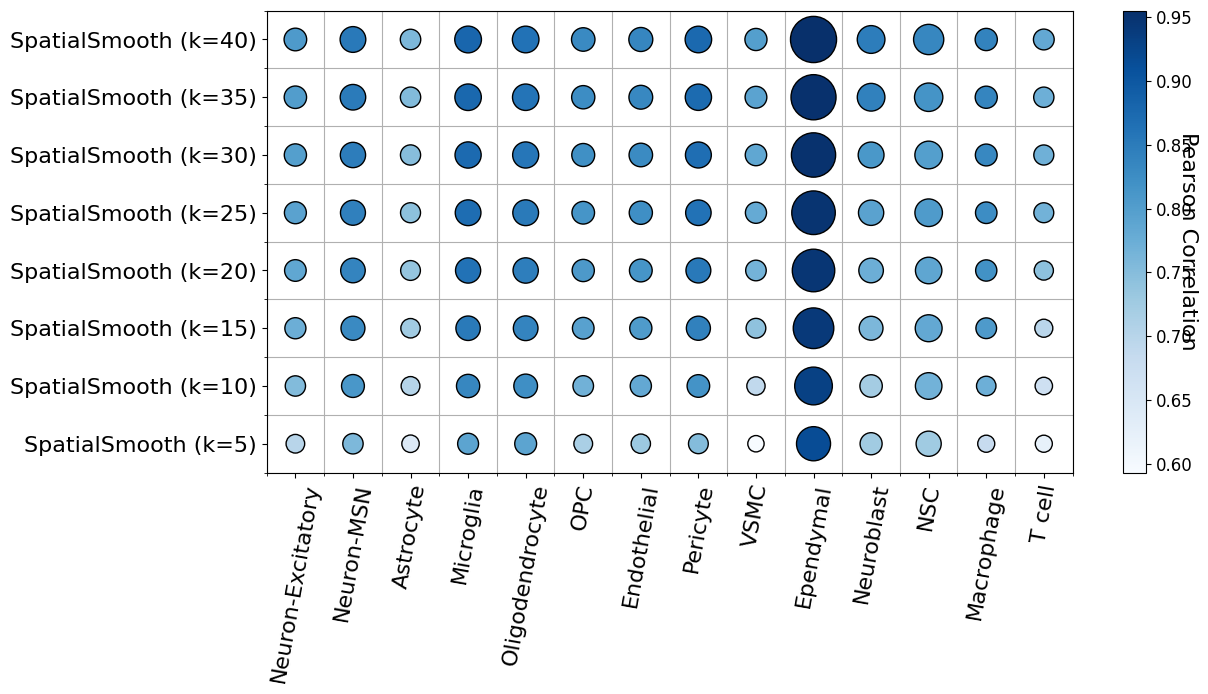

In [4]:
k_values = [5,10,15,20,25,30,35,40]

filepaths = [f"results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh{k}.csv"
             for k in k_values]
names = [f"SpatialSmooth (k={k})" for k in k_values]

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories(celltypes_full)
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(13,0.75*len(k_values)))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="Blues",edgecolor='black',linewidth=1)
ax.add_collection(col)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)


plt.savefig("plots/clocks/comparison_train_test_same_SpatialSmooth_diffK.pdf", bbox_inches='tight')
plt.show()

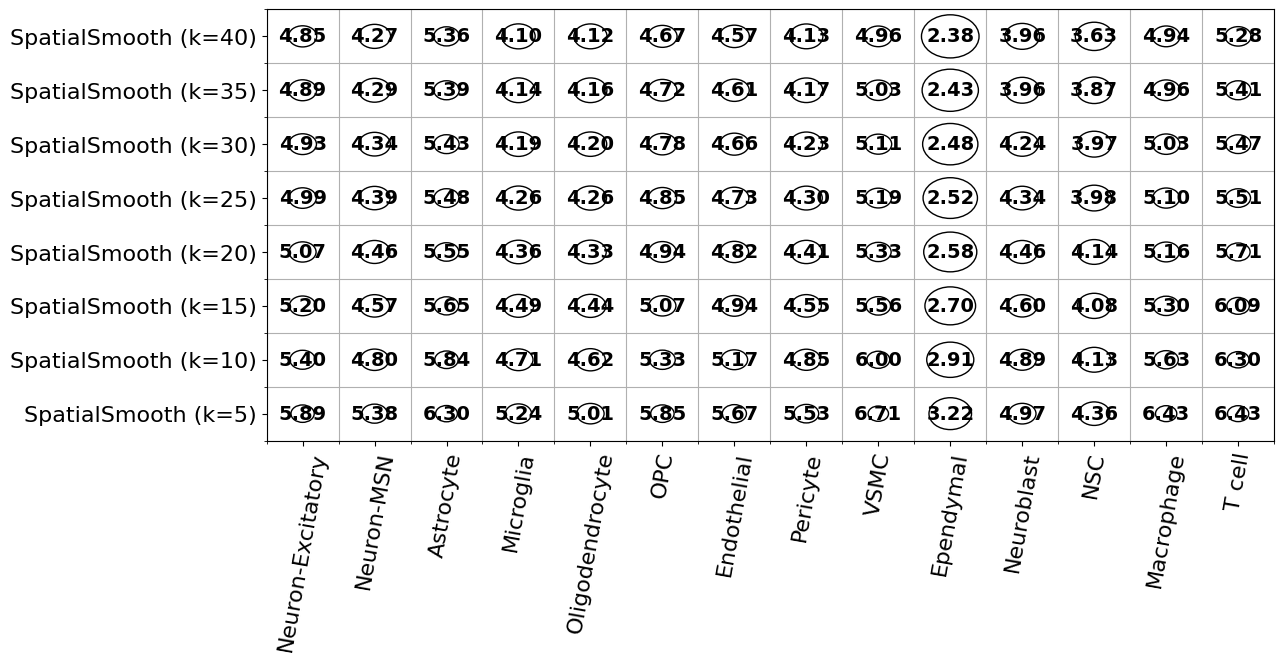

In [5]:
k_values = [5,10,15,20,25,30,35,40]

filepaths = [f"results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh{k}.csv"
             for k in k_values]
names = [f"SpatialSmooth (k={k})" for k in k_values]

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories(celltypes_full)
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(13,0.7*len(k_values)))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
# Create the figure and axis

# Create circles and annotate with mean_abs_err values
for r, j, i, value in zip(R.flat, x.flat, y.flat, comb_df["mean_abs_err"].values):
    circle = plt.Circle((j, i), radius=r, edgecolor='black', linewidth=1, facecolor="None")
    ax.add_patch(circle)
    ax.annotate(f"{value:.2f}", (j, i), color='black', weight='bold', ha='center', va='center', fontsize=14)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)

plt.show()

# Regional performance of global aging clocks

Save performances of the cell type-specific clocks when applied to each region independently (i.e. which regions does it perform better on?)

In [ ]:
# save for each region

adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

nrows = 2
ncols = 9

for region in np.unique(adata.obs.region):
    
    s_adata = adata[adata.obs.region==region,:].copy()
    
    fig, axs = plt.subplots(2, 9, figsize=(24,8), sharex=True, sharey=False)

    celltype_list = []
    r_list = []
    mae_list = []

    counter = 0
    for i in range(nrows):
        for j in range(ncols):

            celltype = list(np.unique(adata.obs['celltype']))[counter]
            
            sub_adata = s_adata[s_adata.obs["celltype"]==celltype,:]
            
            if sub_adata.shape[0] < 2:
                counter += 1            
            
            else:
                # make plot
                axs[i,j].scatter(sub_adata.obs['age'], sub_adata.obs['predicted_age'], alpha=0.1, c='0.5', rasterized=True)
                axs[i,j].set_title(celltype)
                r,p = pearsonr(sub_adata.obs['age'], sub_adata.obs['predicted_age'])
                mae = np.mean(np.abs(sub_adata.obs['age']-sub_adata.obs['predicted_age']))
                axs[i,j].annotate(f"R = {round(r,2)}", (0.3, 0.05), xycoords='axes fraction', fontsize=14)

                # append stats
                celltype_list.append(celltype)
                r_list.append(r)
                mae_list.append(mae)

                counter += 1

    # save stats
    regi = region.split("/")[0]
    stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, mae_list]).T, columns=["celltype", "pearson", "mean_abs_err"])
    stat_df.to_csv(f"results/clocks/stats/{regi}_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv", index=False)

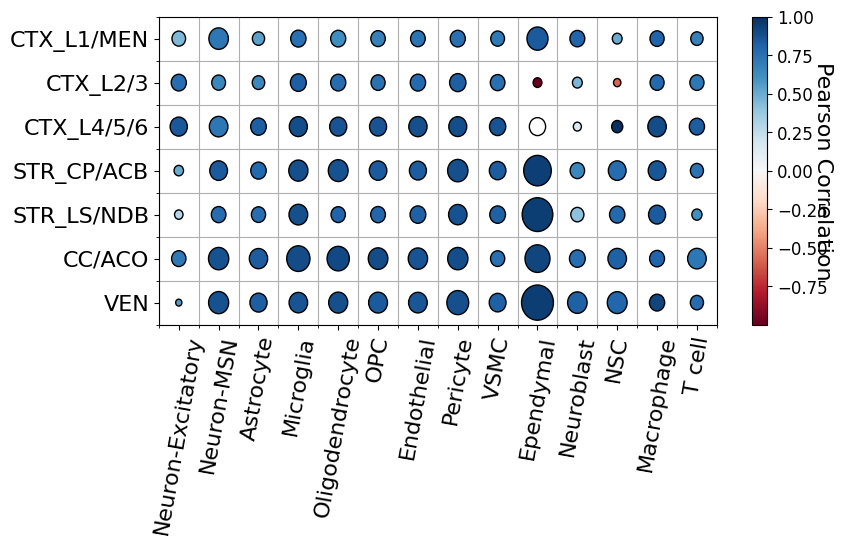

In [40]:
regions = ['VEN', 'CC/ACO', 'STR_LS/NDB', 'STR_CP/ACB',
           'CTX_L4/5/6', 'CTX_L2/3', 'CTX_L1/MEN',]
region_tags = [region.split("/")[0] for region in regions]
filepaths = [f"results/clocks/stats/{regi}_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv" for regi in region_tags]
names = regions

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in df['celltype'].values])
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath+" padding with NaNs")
        new_df = pd.DataFrame([])
        for ct in celltypes:
            if ct in list(df["celltype"]):
                new_df = pd.concat((new_df, df[df["celltype"]==ct]))
            else:
                fill_df = pd.DataFrame(np.array([[ct, 0, 1000, names[i]]]),
                                      columns = ['celltype','pearson','mean_abs_err','name'])
                new_df = pd.concat((new_df, fill_df))
        df = new_df
        df["pearson"] = df["pearson"].astype(float)
        df["mean_abs_err"] = df["mean_abs_err"].astype(float)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(9,4))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="RdBu",edgecolor='black',linewidth=1)
ax.add_collection(col)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)


#plt.tight_layout()
plt.savefig("plots/clocks/comparison_train_test_same_ByRegion.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# PRINT OUT LABELS FOR SIZE LEGEND

regions = ['VEN', 'CC/ACO', 'STR_LS/NDB', 'STR_CP/ACB',
           'CTX_L4/5/6', 'CTX_L2/3', 'CTX_L1/MEN',]
region_tags = [region.split("/")[0] for region in regions]
filepaths = [f"results/clocks/stats/{regi}_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv" for regi in region_tags]
names = regions

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in df['celltype'].values])
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath+" padding with NaNs")
        new_df = pd.DataFrame([])
        for ct in celltypes:
            if ct in list(df["celltype"]):
                new_df = pd.concat((new_df, df[df["celltype"]==ct]))
            else:
                fill_df = pd.DataFrame(np.array([[ct, 0, 1000, names[i]]]),
                                      columns = ['celltype','pearson','mean_abs_err','name'])
                new_df = pd.concat((new_df, fill_df))
        df = new_df
        df["pearson"] = df["pearson"].astype(float)
        df["mean_abs_err"] = df["mean_abs_err"].astype(float)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(9,4))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
# Create circles and annotate with mean_abs_err values
for r, j, i, value in zip(R.flat, x.flat, y.flat, comb_df["mean_abs_err"].values):
    circle = plt.Circle((j, i), radius=r, edgecolor='black', linewidth=1, facecolor="None")
    ax.add_patch(circle)
    ax.annotate(f"{value:.2f}", (j, i), color='black', weight='bold', ha='center', va='center', fontsize=14)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)

plt.show()

### Coarse regions

In [ ]:
# save for each region

adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

coarse_region_mapping = {
    "CC/ACO":"CC/ACO",
    "CTX_L1/MEN":"CTX",
    "CTX_L2/3":"CTX",
    "CTX_L4/5/6":"CTX",
    "STR_CP/ACB":"STR",
    "STR_LS/NDB":"STR",
    "VEN":"VEN",
}
adata.obs["region"] = [coarse_region_mapping[x] for x in adata.obs.region]


nrows = 2
ncols = 9

for region in np.unique(adata.obs.region):
    
    s_adata = adata[adata.obs.region==region,:].copy()
    
    fig, axs = plt.subplots(2, 9, figsize=(24,8), sharex=True, sharey=False)

    celltype_list = []
    r_list = []
    mae_list = []

    counter = 0
    for i in range(nrows):
        for j in range(ncols):

            celltype = list(np.unique(adata.obs['celltype']))[counter]
            
            sub_adata = s_adata[s_adata.obs["celltype"]==celltype,:]
            
            if sub_adata.shape[0] < 2:
                counter += 1            
            
            else:
                # make plot
                axs[i,j].scatter(sub_adata.obs['age'], sub_adata.obs['predicted_age'], alpha=0.1, c='0.5', rasterized=True)
                axs[i,j].set_title(celltype)
                r,p = pearsonr(sub_adata.obs['age'], sub_adata.obs['predicted_age'])
                mae = np.mean(np.abs(sub_adata.obs['age']-sub_adata.obs['predicted_age']))
                axs[i,j].annotate(f"R = {round(r,2)}", (0.3, 0.05), xycoords='axes fraction', fontsize=14)

                # append stats
                celltype_list.append(celltype)
                r_list.append(r)
                mae_list.append(mae)

                counter += 1

    # save stats
    regi = region.split("/")[0]
    stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, mae_list]).T, columns=["celltype", "pearson", "mean_abs_err"])
    stat_df.to_csv(f"results/clocks/stats/{regi}coarse_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv", index=False)

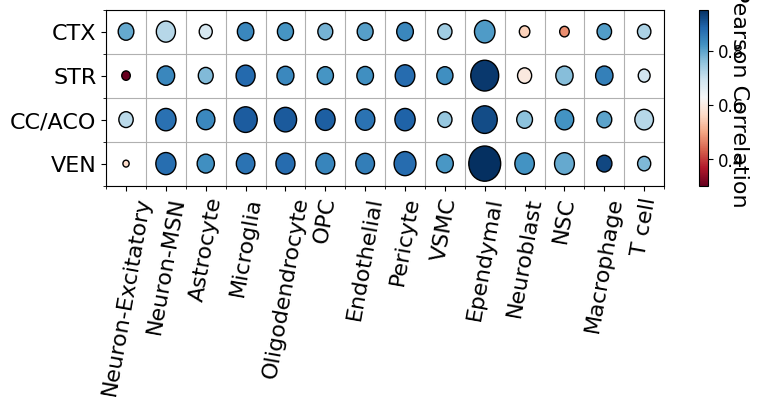

In [6]:
regions = ['VEN', 'CC/ACO', 'STR', 'CTX']
region_tags = [region.split("/")[0] for region in regions]
filepaths = [f"results/clocks/stats/{regi}coarse_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv" for regi in region_tags]
names = regions

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in df['celltype'].values])
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath+" padding with NaNs")
        new_df = pd.DataFrame([])
        for ct in celltypes:
            if ct in list(df["celltype"]):
                new_df = pd.concat((new_df, df[df["celltype"]==ct]))
            else:
                fill_df = pd.DataFrame(np.array([[ct, 0, 1000, names[i]]]),
                                      columns = ['celltype','pearson','mean_abs_err','name'])
                new_df = pd.concat((new_df, fill_df))
        df = new_df
        df["pearson"] = df["pearson"].astype(float)
        df["mean_abs_err"] = df["mean_abs_err"].astype(float)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(9,16/7))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="RdBu",edgecolor='black',linewidth=1)
ax.add_collection(col)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)


#plt.tight_layout()
plt.savefig("plots/clocks/comparison_train_test_same_ByRegionCoarse.pdf", bbox_inches='tight')
plt.show()

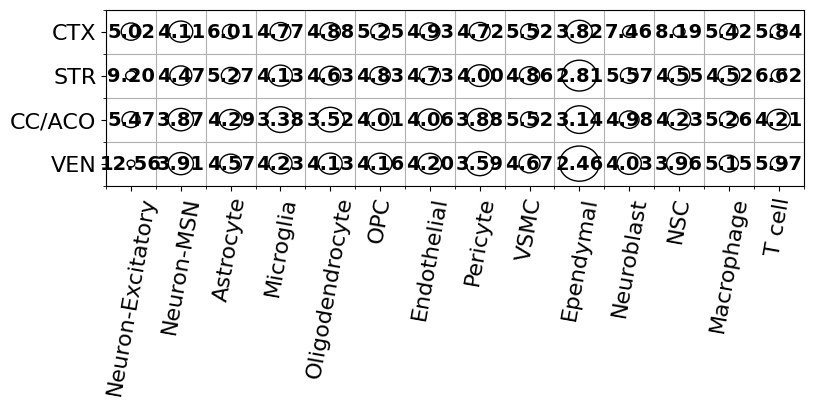

In [7]:
regions = ['VEN', 'CC/ACO', 'STR', 'CTX']
region_tags = [region.split("/")[0] for region in regions]
filepaths = [f"results/clocks/stats/{regi}coarse_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv" for regi in region_tags]
names = regions

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']


###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in df['celltype'].values])
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath+" padding with NaNs")
        new_df = pd.DataFrame([])
        for ct in celltypes:
            if ct in list(df["celltype"]):
                new_df = pd.concat((new_df, df[df["celltype"]==ct]))
            else:
                fill_df = pd.DataFrame(np.array([[ct, 0, 1000, names[i]]]),
                                      columns = ['celltype','pearson','mean_abs_err','name'])
                new_df = pd.concat((new_df, fill_df))
        df = new_df
        df["pearson"] = df["pearson"].astype(float)
        df["mean_abs_err"] = df["mean_abs_err"].astype(float)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(9,16/7))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
# Create circles and annotate with mean_abs_err values
for r, j, i, value in zip(R.flat, x.flat, y.flat, comb_df["mean_abs_err"].values):
    circle = plt.Circle((j, i), radius=r, edgecolor='black', linewidth=1, facecolor="None")
    ax.add_patch(circle)
    ax.annotate(f"{value:.2f}", (j, i), color='black', weight='bold', ha='center', va='center', fontsize=14)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)

plt.show()

## Buckley et al. 2023

In [4]:
df = pd.read_csv("results/buckley/predictions_dataframe.csv", sep=" ")
df = df.rename(columns={"Mouse":"mouse_id", "Age":"age", "Celltype":"celltype", "Prediction":"predicted_age"})

# load in from buckley et al. (slightly different since groupby + mutate than approach but values highly similar)
df_med = pd.read_csv("results/buckley/predictions_dataframe_medians.csv", sep=" ")
df_med = df_med.rename(columns={"Mouse":"mouse_id", "Age":"age", "Celltype":"celltype", "med":"predicted_age"})

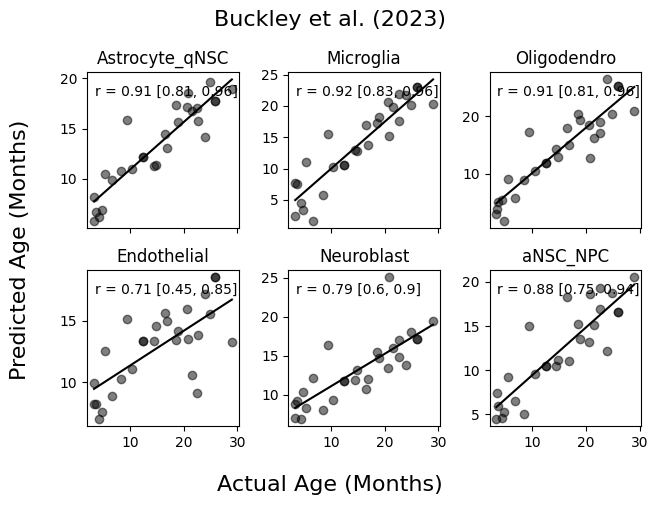

In [11]:
nrows = 2
ncols = 3

fig, axs = plt.subplots(nrows, ncols, figsize=(20*1/3,5), sharex=True, sharey=False)

celltype_list = []
r_list = []
r_list_median = []
mae_list = []

celltypes_order = ["Astrocyte_qNSC", "Microglia", "Oligodendro", "Endothelial", "Neuroblast", "aNSC_NPC"]

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = celltypes_order[counter]
        sub_df = df[df["celltype"]==celltype].copy()
        sub_df_med = df_med[df_med["celltype"]==celltype].copy()
        
        # make plot
        axs[i,j].scatter(sub_df_med["age"], sub_df_med["predicted_age"], c='k', alpha=0.5)
        b, a = np.polyfit(sub_df_med["age"], sub_df_med["predicted_age"], deg=1)
        xseq = np.linspace(np.min(sub_df['age']),np.max(sub_df['age']),100)
        axs[i,j].plot(xseq, a + b * xseq, color="k")
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_df['age'], sub_df['predicted_age'])
        ci = correlation_confidence_interval(r,len(sub_df['age']),0.95)
        r_med,p_med = pearsonr(sub_df_med["age"], sub_df_med["predicted_age"])
        ci_med = correlation_confidence_interval(r_med,len(sub_df_med["age"]),0.95)
        mae = np.mean(np.abs(sub_df['age']-sub_df['predicted_age']))
        axs[i,j].annotate(f"r = {round(r_med,2)} [{round(ci_med[0],2)}, {round(ci_med[1],2)}]", (0.05, 0.85), xycoords='axes fraction', fontsize=10)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        r_list_median.append(r_med)
        
        counter += 1

# make figure
fig.suptitle("Buckley et al. (2023)", fontsize=16)
fig.supxlabel("Actual Age (Months)", fontsize=16)
fig.supylabel("Predicted Age (Months)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/clocks/pseudobulked/buckley_2023_six_celltypes.pdf",
            bbox_inches='tight')
plt.show()


# save stats
stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, r_list_median, mae_list]).T, columns=["celltype", "pearson", "pearson_median", "mean_abs_err"])
stat_df.to_csv("results/clocks/stats/buckley_2023_six_celltypes.csv", index=False)